In [1]:
from tools import utils, config, trainer, parts
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import functional as F
from tools import utils
import torch.nn as nn

plt.style.use('fast')
PLOT_DIR = 'plots'

cfg = config.from_yaml("experiments\exp9_net6\config.yaml")
dataset = utils.load_dataset_module(**cfg.data_supervised)
dataset.torch_seed()
test_loader = dataset.get_test_loader(**cfg.data_supervised)
test_dataset = dataset.get_test_dataset()

# Trained model
model_trained = utils.load_model(**cfg.model)

part_manager_trained = parts.PartManager(model_trained)
part_manager_trained.enable_all()

i_part = 1
trn_trained = trainer.ModelTrainer(model_trained, cfg.trainer_sup, part_manager_trained)
model_trained.load_state_dict(torch.load("experiments\exp9_net6\checkpoint.pth"))
model_trained.eval();

Loading dataset: data\cifar10.py
Files already downloaded and verified
Files already downloaded and verified
Created 10 parts.
Enable all parts
checkpoint to cuda:0


In [2]:
from autoattack import AutoAttack
from tqdm import tqdm

def get_acc_autoattack(model, device, loader):
    correct = 0
    n_examples = 0

    adversary = AutoAttack(model_trained, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'])
    x_all = []
    y_all = []
    for x, y in tqdm(loader):
        x_all.append(x)
        y_all.append(y)
        n_examples += x.shape[0]
        
    x_all = torch.concat(x_all, dim=0).to(device)
    y_all = torch.concat(y_all, dim=0).to(device)
    
    SAMPLE_SIZE = 1000
    sample_idx = np.random.choice(len(x_all), SAMPLE_SIZE, replace=False)
    x_all = x_all[sample_idx]
    y_all = y_all[sample_idx]
        
    x_all_attack, y_all_attack = adversary.run_standard_evaluation(x_all, y_all, bs=250, return_labels=True)
    return x_all_attack, y_all, y_all_attack

### Get samples from each class

In [3]:
N_CLASSES = 10
class_size = 50
classes_to_accumulate = list(range(N_CLASSES))
examples = {i: [] for i in range(N_CLASSES)}

i = 0
while True:
    x, y = test_dataset[i]
    if not y in classes_to_accumulate:
        i+=1
        continue
    
    examples[y].append(i)
    if len(examples[y]) == class_size:
        classes_to_accumulate.remove(y)
        if len(classes_to_accumulate) == 0:
            break
    i+=1

### Regular Examples

In [4]:
extract_layer = model_trained.se1

part_output_trained_list = [[] for _ in range(N_CLASSES)]
y_preds = []
y_s = []

for class_i, class_examples in examples.items():
    for example_i in class_examples:
        x, y = test_dataset[example_i]
        x = x.unsqueeze(0).to(trn_trained.device)
        
        y_pred = model_trained(x)
        y_pred = np.argmax(y_pred.cpu().detach().numpy())
        y_s.append(y)
        y_preds.append(y_pred)
        
        part_output_trained = extract_layer.sigmoid_output
        part_output_trained = torch.squeeze(part_output_trained).cpu().detach().numpy()
        part_output_trained_list[class_i].append(part_output_trained)

print(f"acc: {(np.array(y_preds) == np.array(y_s)).mean()}")
activations_trained = np.array(part_output_trained_list)
activations_trained.shape # i_class, i_example, i_kernel, h, w

D:\Miniconda3\envs\env\lib\site-packages\torch\nn\modules\module.py:1102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return forward_call(*input, **kwargs)


acc: 0.708


(10, 50, 20)

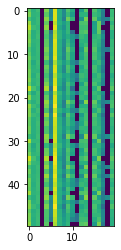

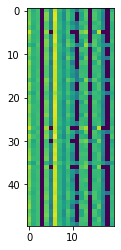

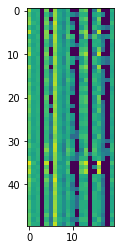

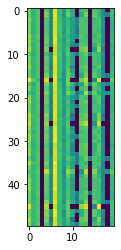

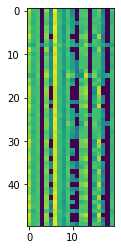

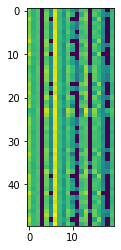

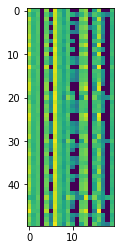

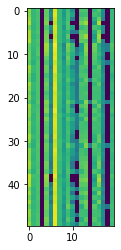

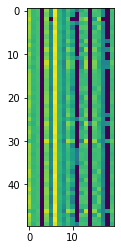

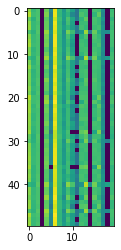

In [5]:
x_plot = activations_trained
for class_i in range(N_CLASSES):
    plt.figure(figsize=(25, 4))
    plt.imshow(x_plot[class_i])

In [6]:
x_att, y_att, y_false = get_acc_autoattack(model_trained, trn_trained.device, test_loader)

100%|██████████| 400/400 [00:01<00:00, 247.59it/s]


using custom version including apgd-ce, apgd-dlr
initial accuracy: 72.90%
apgd-ce - 1/3 - 250 out of 250 successfully perturbed
apgd-ce - 2/3 - 250 out of 250 successfully perturbed
apgd-ce - 3/3 - 229 out of 229 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 10.1 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%


In [7]:
N_CLASSES = 10
class_size = 50
classes_to_accumulate = list(range(N_CLASSES))
examples = {i: [] for i in range(N_CLASSES)}

for i in range(len(x_att)):
    x, y = x_att[i], y_att[i].cpu().detach().numpy().item()
    if not y in classes_to_accumulate:
        continue
    
    examples[y].append(i)
    if len(examples[y]) == class_size:
        classes_to_accumulate.remove(y)
        if len(classes_to_accumulate) == 0:
            break

extract_layer = model_trained.se1

part_output_trained_list = [[] for _ in range(N_CLASSES)]
y_preds = []
y_s = []

for class_i, class_examples in examples.items():
    for example_i in class_examples:
        x, y = x_att[i], y_att[i]
        x = x.unsqueeze(0).to(trn_trained.device)
        
        y_pred = model_trained(x)
        y_pred = np.argmax(y_pred.cpu().detach().numpy())
        y_s.append(y)
        y_preds.append(y_pred)
        
        part_output_trained = extract_layer.sigmoid_output
        part_output_trained = torch.squeeze(part_output_trained).cpu().detach().numpy()
        part_output_trained_list[class_i].append(part_output_trained)

print(f"acc: {(np.array(y_preds) == np.array(y_s)).mean()}")
activations_trained = np.array(part_output_trained_list)
activations_trained.shape # i_class, i_example, i_kernel, h, w

acc: 0.0


(10, 50, 20)

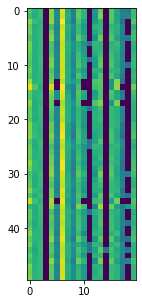

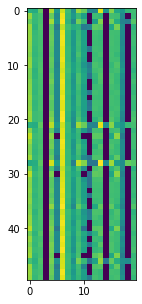

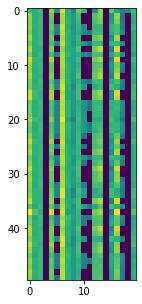

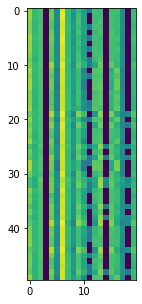

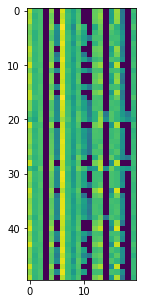

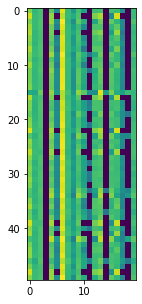

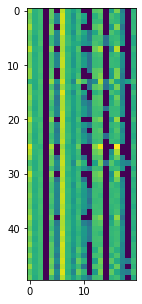

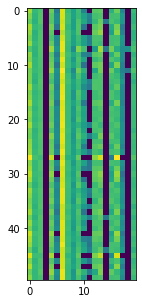

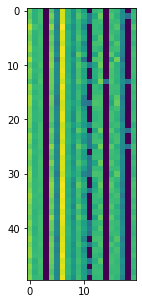

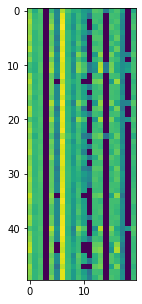

In [8]:
x_plot = activations_trained
for class_i in range(N_CLASSES):
    plt.figure(figsize=(25, 5))
    plt.imshow(x_plot[class_i])